In [110]:
import torch
from transformers import BertTokenizer, BertModel, BertConfig
import numpy as np
import matplotlib.pyplot as plt

from xai_transformer import BertAttention
from xai_transformer import LNargsDetach, LNargsInterpolatedDetach
from utils import LayerNorm, flip

In [58]:
bert_config = BertConfig.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [85]:
class SimpleConfig:
    hidden_size = bert_config.hidden_size
    all_head_size = bert_config.hidden_size
    num_attention_heads = bert_config.num_attention_heads
    attention_head_size = bert_config.hidden_size // bert_config.num_attention_heads
    n_blocks = 4
    n_classes = 2
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cuda'
    train_mode = False

    # complete detached run
    detach_layernorm = True
    detach_mean = True
    detach_kq = True

    layer_norm_eps = 1e-5

    #
    lnv = 'nowb'
    sigma = None
    adanorm_scale = 1.
    nowb_scale = None
    layer_norm_eps = 1e-5

    # gating parameters (grid searched over small space)
    gamma_LN = 1
    gamma_AH = 1

In [86]:
config = SimpleConfig()

In [87]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,


In [88]:
text = "This movie was absolutely wonderful, I loved it."

In [89]:
encoding = tokenizer(text, return_tensors='pt')
input_ids = encoding["input_ids"].to(config.device)
print("Token IDs:", input_ids)

Token IDs: tensor([[ 101, 2023, 3185, 2001, 7078, 6919, 1010, 1045, 3866, 2009, 1012,  102]],
       device='cuda:0')


In [90]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Some weights of the model check

In [91]:
hf_embeddings = bert_model.embeddings
hf_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [92]:
## we have replaced the LayerNorm by our custom no gradient implementation
from utils import LayerNorm

hf_embeddings.LayerNorm = LayerNorm(bert_config.hidden_size,
                                 eps = bert_config.layer_norm_eps,
                                 args = LNargsInterpolatedDetach(gamma_LN = config.gamma_LN))

In [93]:
embeddings = hf_embeddings

In [94]:
model = BertAttention(config, embeddings).to(config.device)
# print(f"Config gammas: {config.gamma_LN}, {config.gamma_AH}")
print("\nModel initialized. Running baseline explanation...\n")

Detach K-Q-softmax branch
Detach K-Q-softmax branch
Detach K-Q-softmax branch
Detach K-Q-softmax branch

Model initialized. Running baseline explanation...



In [95]:
# sanity check
for i, block in enumerate(model.attention_layers):
    print(i, "detach:", block.detach)

0 detach: True
1 detach: True
2 detach: True
3 detach: True


In [96]:
# debug check
print("Embedding LN:", type(embeddings.LayerNorm))
print("Embedding LN device:", embeddings.LayerNorm.weight.device)

print()
print("Block LN types:")
for i, block in enumerate(model.attention_layers):
    print(i, type(block.output.LayerNorm))

print()
print("Detach flags:")
print("detach_kq:", config.detach_kq)
print("detach_layernorm:", config.detach_layernorm)
print("detach_mean:", config.detach_mean)
print("device:", config.device)

Embedding LN: <class 'utils.LayerNormImpl'>
Embedding LN device: cuda:0

Block LN types:
0 <class 'utils.LayerNormImpl'>
1 <class 'utils.LayerNormImpl'>
2 <class 'utils.LayerNormImpl'>
3 <class 'utils.LayerNormImpl'>

Detach flags:
detach_kq: True
detach_layernorm: True
detach_mean: True
device: cuda


In [97]:
target_class = 1

result = model.forward_and_explain(
    input_ids=input_ids,
    cl=target_class
)

relevance = result["R"] # shape: [1, seq_len]
logits = result["logits"]

f_x = logits[0, target_class].item()
sum_relevance = float(np.sum(relevance))

print("Conservation Check\n")
print("Model output f(x): \n", f_x)
print()

print("Sum of relevance R(x_i):\n", sum_relevance)
print()

print("Difference:\n", abs(f_x - sum_relevance))
print()

DEBUG: gamma_LN inside LN = 1
DEBUG: gamma_AH inside attention = 1
DEBUG: gamma_LN inside LN = 1
DEBUG: gamma_AH inside attention = 1
DEBUG: gamma_LN inside LN = 1
DEBUG: gamma_AH inside attention = 1
DEBUG: gamma_LN inside LN = 1
DEBUG: gamma_AH inside attention = 1
DEBUG: gamma_LN inside LN = 1
Conservation Check

Model output f(x): 
 -0.3485358655452728

Sum of relevance R(x_i):
 0.0469927042722702

Difference:
 0.39552856981754303



## Benchmarking on SST-2 Validation split

In [98]:
from datasets import load_dataset

dataset = load_dataset("glue", "sst2")
val_data = dataset["validation"]

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [99]:
val_data

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 872
})

In [100]:
texts = [example["sentence"] for example in val_data]
labels = [example["label"] for example in val_data]

In [101]:
texts[:2], labels[:2]

(["it 's a charming and often affecting journey . ",
  'unflinchingly bleak and desperate '],
 [1, 0])

### Quick check

In [102]:
config.gamma_AH, config.gamma_LN

(1, 1)

In [103]:
print("model.config.gamma_AH, gamma_LN =", model.config.gamma_AH, model.config.gamma_LN)
# Also update internal LN modules if needed (safe)
for n,m in model.named_modules():
    if hasattr(m, 'gamma_LN'):
        m.gamma_LN = float(model.config.gamma_LN)

model.config.gamma_AH, gamma_LN = 1 1


In [105]:
for i, block in enumerate(model.attention_layers):
    print(i, id(block.config), id(config))

0 139171537329840 139171537329840
1 139171537329840 139171537329840
2 139171537329840 139171537329840
3 139171537329840 139171537329840


### Completeness tests

In [108]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

gamma_values = [0.0, 0.25, 0.5, 0.75, 1.0]

N_SAMPLES = 200   # set to smaller number to test quickly; set to len(texts) for full run

fracs = np.linspace(0., 1., 11)

device = config.device if hasattr(config, 'device') else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# tiny helper to ensure label -> tensor
def label_to_tensor(y, device):
    if isinstance(y, torch.Tensor):
        return y.to(device).long()
    else:
        return torch.tensor(int(y), dtype=torch.long, device=device)

def evaluate_gamma_pair(gAH, gLN, model, texts, labels, n_samples=N_SAMPLES):
    # set gammas in config (global control)
    model.config.gamma_AH = float(gAH)
    model.config.gamma_LN = float(gLN)

    model.eval()

    # completeness
    completeness_errors = []
    # perturbation metrics
    auac_list = []
    aumse_list = []

    # iterate examples (limit to n_samples)
    total = min(n_samples, len(texts))
    for i in range(total):
        text = texts[i]
        label = labels[i]
        enc = tokenizer(text, return_tensors='pt', truncation=True)
        input_ids = enc['input_ids'].to(device)

        # forward_and_explain returns {'logits','R',...}
        res = model.forward_and_explain(input_ids=input_ids, cl=int(label))
        R = res['R'].flatten()
        logit_val = float(res['logits'][0, int(label)])

        # completeness error
        s = float(np.sum(R))
        completeness_errors.append(abs(logit_val - s))

        # perturbation metrics using flip
        # activation (generate)
        y_true_tensor = label_to_tensor(label, device)
        mse_gen, evidence, _ = flip(model, R, input_ids, tokenizer.tokenize(text),
                                    y_true=y_true_tensor, fracs=fracs, flip_case='generate',
                                    tokenizer=tokenizer, device=device)
        auac = np.trapz(evidence, fracs)
        auac_list.append(auac)

        # pruning
        mse_prune, ev, _ = flip(model, R, input_ids, tokenizer.tokenize(text),
                                y_true=y_true_tensor, fracs=fracs, flip_case='pruning',
                                tokenizer=tokenizer, device=device)
        aumse = np.trapz(mse_prune, fracs)
        aumse_list.append(aumse)

    # aggregate
    mean_completeness = float(np.mean(completeness_errors)) if len(completeness_errors) else float('nan')
    mean_auac = float(np.mean(auac_list)) if len(auac_list) else float('nan')
    mean_aumse = float(np.mean(aumse_list)) if len(aumse_list) else float('nan')

    return mean_completeness, mean_auac, mean_aumse

Using device: cuda


In [111]:
import torch, copy, pickle, gc
from tqdm import tqdm

results = {}
gamma_values = [0.0, 0.25, 0.5, 0.75, 1.0]
N_SAMPLES = 200
save_path = "gamma_sweep_results_intermediate.pkl"

base_embeds = hf_embeddings

for gAH in gamma_values:
    for gLN in gamma_values:
        print(f"\n=== Building model for γ_AH={gAH}, γ_LN={gLN} ===")

        # 1) set gammas in config BEFORE creating LayerNorm / model
        config.gamma_AH = float(gAH)
        config.gamma_LN = float(gLN)

        # 2) create a fresh copy of embeddings (to avoid mutating shared module in weird ways)
        # shallow copy the module so we don't permanently overwrite the global object
        embeddings = copy.deepcopy(base_embeds)
        embeddings.LayerNorm = LayerNorm(
            bert_config.hidden_size,
            eps=bert_config.layer_norm_eps,
            args=LNargsInterpolatedDetach(gamma_LN=config.gamma_LN)
        ).to(config.device)

        embeddings = embeddings.to(config.device)

        # 3) build model with this config and embeddings
        model = BertAttention(config, embeddings)
        model.to(config.device)
        model.eval()

        # 4) run evaluation for this pair
        # SHORT SUMMARY BEFORE RUNNING EVALUATIONS
        print("config:", config.gamma_AH, config.gamma_LN)
        for i, block in enumerate(model.attention_layers):
            print(f"block{i} gamma_AH:", block.config.gamma_AH)
        # confirm LNs
        for name, m in model.named_modules():
            if hasattr(m, "gamma_LN"):
                print(name, m.gamma_LN)

        print(f"Evaluating γ_AH={gAH:.2f}, γ_LN={gLN:.2f} ...")
        c, au, am = evaluate_gamma_pair(gAH, gLN, model, texts, labels, n_samples=N_SAMPLES)
        results[(gAH, gLN)] = {'completeness': c, 'auac': au, 'aumse': am}
        print(f" -> completeness={c:.6f}, auac={au:.6f}, aumse={am:.6f}")

        # Save progress after each pair so you don't lose work if the run dies
        pickle.dump({'gamma_values': gamma_values, 'results': results, 'N_SAMPLES': N_SAMPLES}, open(save_path, 'wb'))

        # 5) cleanup: delete model & free GPU memory
        del model
        del embeddings
        torch.cuda.empty_cache()
        gc.collect()


=== Building model for γ_AH=0.0, γ_LN=0.0 ===
Detach K-Q-softmax branch
Detach K-Q-softmax branch
Detach K-Q-softmax branch
Detach K-Q-softmax branch
config: 0.0 0.0
block0 gamma_AH: 0.0
block1 gamma_AH: 0.0
block2 gamma_AH: 0.0
block3 gamma_AH: 0.0
embeds.LayerNorm 0.0
attention_layers.0.output.LayerNorm 0.0
attention_layers.1.output.LayerNorm 0.0
attention_layers.2.output.LayerNorm 0.0
attention_layers.3.output.LayerNorm 0.0
output.LayerNorm 0.0
Evaluating γ_AH=0.00, γ_LN=0.00 ...
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH insid

/content/utils.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs0 = torch.tensor(token_ids).to(device)
/tmp/ipython-input-3995049768.py:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auac = np.trapz(evidence, fracs)


DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH inside attention = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_LN inside LN = 0.0
DEBUG: gamma_AH insi

/tmp/ipython-input-3995049768.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aumse = np.trapz(mse_prune, fracs)


Streaming output truncated to the last 5000 lines.
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
DEBUG: gamma_AH inside attention = 1.0
DEBUG: gamma_LN inside LN = 1.0
D

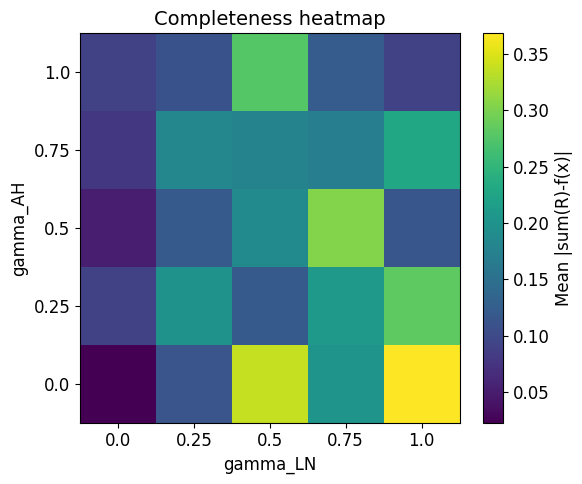

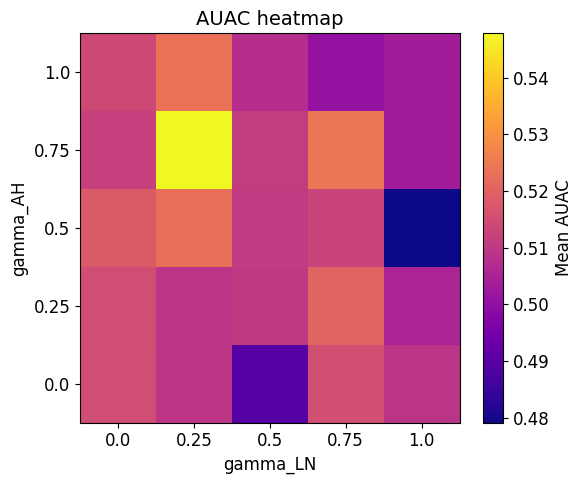

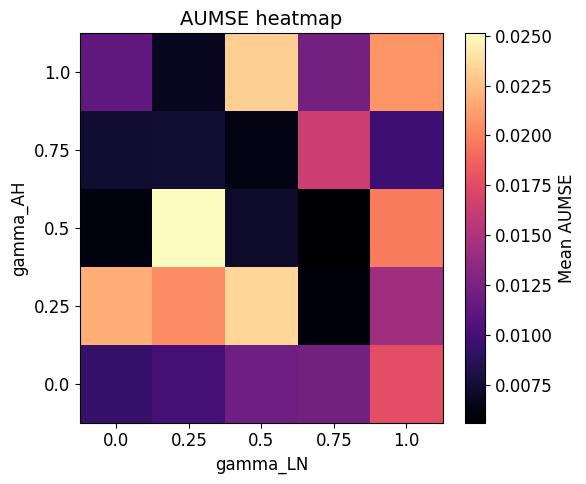

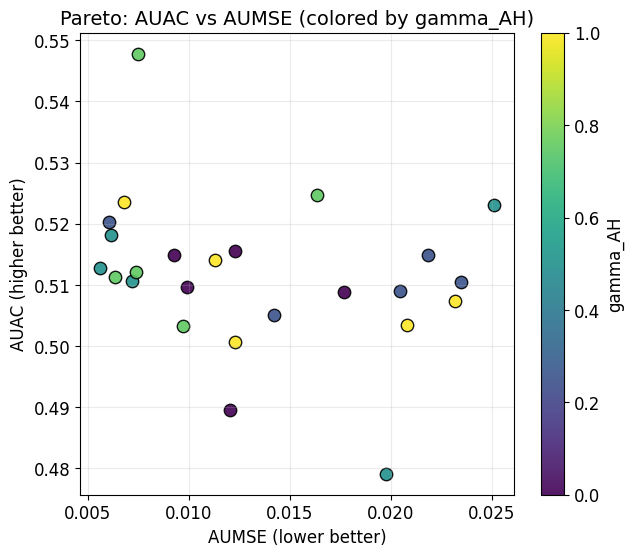

In [112]:
import matplotlib.pyplot as plt

# build matrices (rows = gamma_AH, cols = gamma_LN)
n = len(gamma_values)
Cmat = np.zeros((n, n))
AUmat = np.zeros((n, n))
AMmat = np.zeros((n, n))

for i, gAH in enumerate(gamma_values):
    for j, gLN in enumerate(gamma_values):
        r = results[(gAH, gLN)]
        Cmat[i, j] = r['completeness']
        AUmat[i, j] = r['auac']
        AMmat[i, j] = r['aumse']

# pretty plotting params
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "figure.figsize": (6, 5)
})

# Completeness heatmap
plt.figure()
plt.imshow(Cmat, origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label="Mean |sum(R)-f(x)|")
plt.xticks(range(n), gamma_values)
plt.yticks(range(n), gamma_values)
plt.xlabel("gamma_LN")
plt.ylabel("gamma_AH")
plt.title("Completeness heatmap")
plt.tight_layout()
plt.show()

# AUAC heatmap
plt.figure()
plt.imshow(AUmat, origin='lower', cmap='plasma', interpolation='nearest', aspect='auto')
plt.colorbar(label="Mean AUAC")
plt.xticks(range(n), gamma_values)
plt.yticks(range(n), gamma_values)
plt.xlabel("gamma_LN")
plt.ylabel("gamma_AH")
plt.title("AUAC heatmap")
plt.tight_layout()
plt.show()

# AUMSE heatmap
plt.figure()
plt.imshow(AMmat, origin='lower', cmap='magma', interpolation='nearest', aspect='auto')
plt.colorbar(label="Mean AUMSE")
plt.xticks(range(n), gamma_values)
plt.yticks(range(n), gamma_values)
plt.xlabel("gamma_LN")
plt.ylabel("gamma_AH")
plt.title("AUMSE heatmap")
plt.tight_layout()
plt.show()

# Pareto scatter (AUMSE vs AUAC), colored by gamma_AH (example)
plt.figure(figsize=(7,6))
for (gAH, gLN), r in results.items():
    plt.scatter(r['aumse'], r['auac'], s=80, c=[gAH], cmap='viridis', vmin=0, vmax=1, edgecolor='k', alpha=0.9)
plt.xlabel("AUMSE (lower better)")
plt.ylabel("AUAC (higher better)")
plt.title("Pareto: AUAC vs AUMSE (colored by gamma_AH)")
cb = plt.colorbar()
cb.set_label("gamma_AH")
plt.grid(alpha=0.25)
plt.show()


## Analysis plots

In [113]:
pickle_path = r"/content/gamma_sweep_results_intermediate.pkl"

In [114]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import pearsonr, spearmanr


=== gamma_AH vs Completeness ===
Pearson r = -0.2440, p = 0.2397
Spearman ρ = -0.2236, p = 0.2827


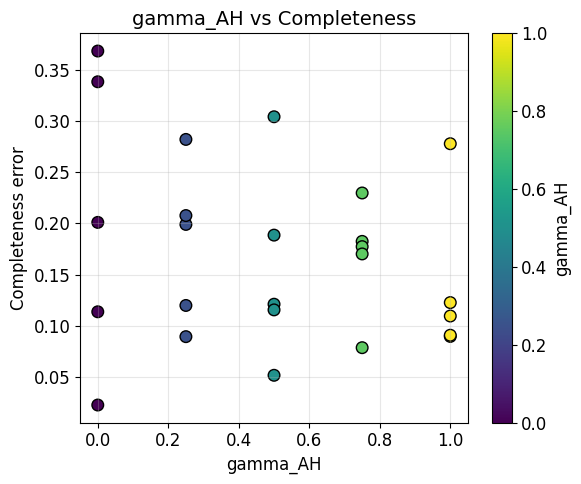


=== gamma_AH vs AUAC ===
Pearson r = 0.1399, p = 0.5047
Spearman ρ = 0.0431, p = 0.8377


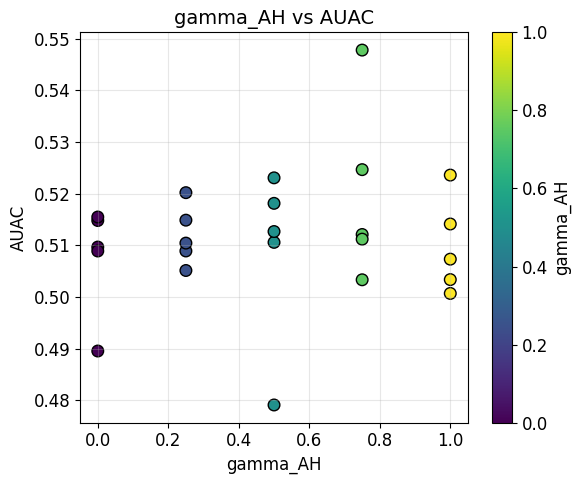


=== gamma_AH vs AUMSE ===
Pearson r = -0.0561, p = 0.7900
Spearman ρ = -0.0784, p = 0.7094


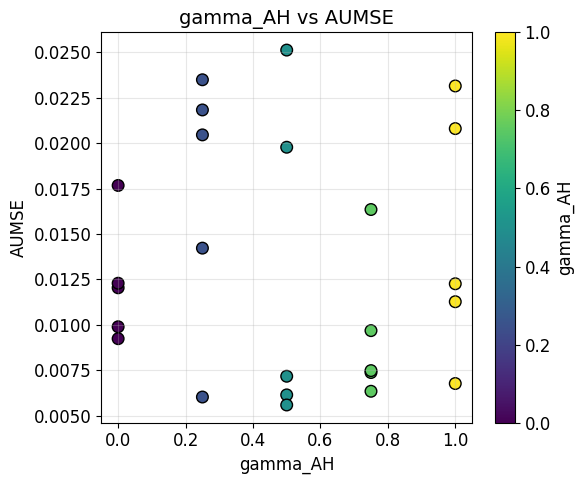


=== gamma_LN vs Completeness ===
Pearson r = 0.5693, p = 0.0030
Spearman ρ = 0.6315, p = 0.0007


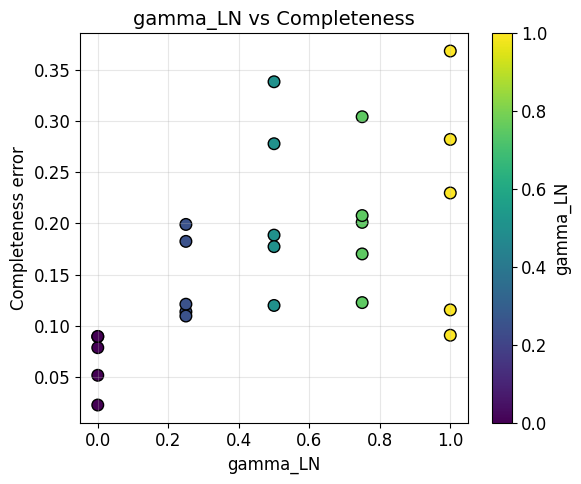


=== gamma_LN vs AUAC ===
Pearson r = -0.4310, p = 0.0315
Spearman ρ = -0.5060, p = 0.0099


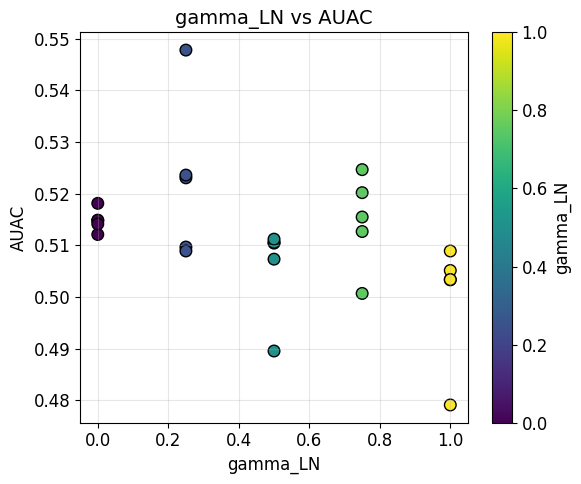


=== gamma_LN vs AUMSE ===
Pearson r = 0.1581, p = 0.4505
Spearman ρ = 0.1647, p = 0.4313


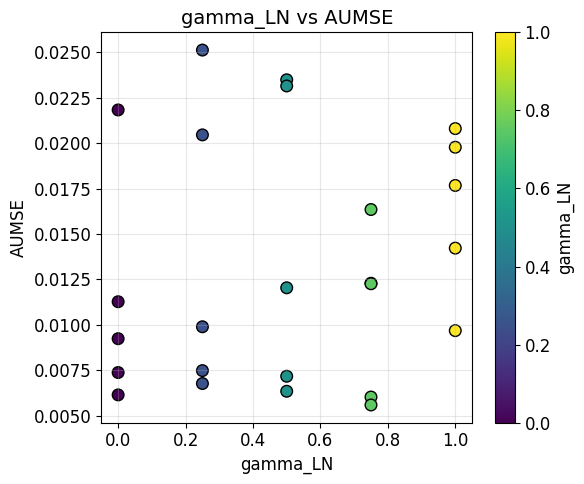

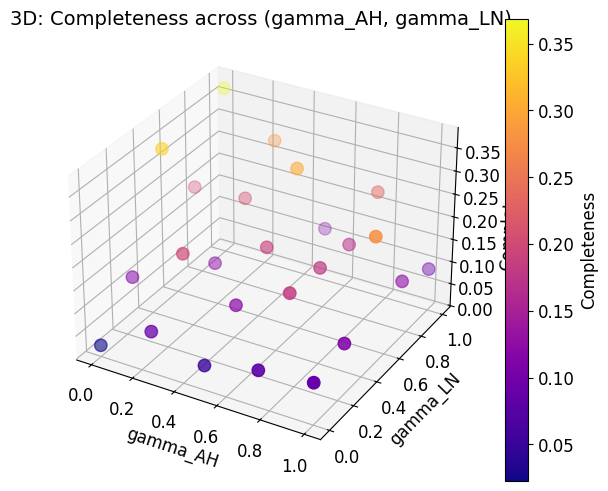

In [115]:
data = pickle.load(open(pickle_path, "rb"))

gamma_values = data["gamma_values"]
results = data["results"]

# ----------------------------------------------
# Convert results into arrays for analysis
# ----------------------------------------------
gAH_list = []
gLN_list = []
comp_list = []
auac_list = []
aumse_list = []

for (gAH, gLN), vals in results.items():
    gAH_list.append(gAH)
    gLN_list.append(gLN)
    comp_list.append(vals["completeness"])
    auac_list.append(vals["auac"])
    aumse_list.append(vals["aumse"])

gAH_arr = np.array(gAH_list)
gLN_arr = np.array(gLN_list)
comp_arr = np.array(comp_list)
auac_arr = np.array(auac_list)
aumse_arr = np.array(aumse_list)

# ----------------------------------------------
# Helper function for scatter + correlation print
# ----------------------------------------------
def plot_relation(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(6,5))
    plt.scatter(x, y, s=70, c=x, cmap="viridis", edgecolor="k")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Pearson + Spearman correlations
    pr, pp = pearsonr(x, y)
    sr, sp = spearmanr(x, y)
    print(f"\n=== {title} ===")
    print(f"Pearson r = {pr:.4f}, p = {pp:.4f}")
    print(f"Spearman ρ = {sr:.4f}, p = {sp:.4f}")

    plt.colorbar(label=xlabel)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------
# 1) gamma_AH relations
# ------------------------------------------------
plot_relation(gAH_arr, comp_arr, "gamma_AH", "Completeness error", "gamma_AH vs Completeness")
plot_relation(gAH_arr, auac_arr, "gamma_AH", "AUAC", "gamma_AH vs AUAC")
plot_relation(gAH_arr, aumse_arr, "gamma_AH", "AUMSE", "gamma_AH vs AUMSE")

# ------------------------------------------------
# 2) gamma_LN relations
# ------------------------------------------------
plot_relation(gLN_arr, comp_arr, "gamma_LN", "Completeness error", "gamma_LN vs Completeness")
plot_relation(gLN_arr, auac_arr, "gamma_LN", "AUAC", "gamma_LN vs AUAC")
plot_relation(gLN_arr, aumse_arr, "gamma_LN", "AUMSE", "gamma_LN vs AUMSE")

# ------------------------------------------------
# 3) Joint 3D scatter plot (optional)
# ------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(gAH_arr, gLN_arr, comp_arr, c=comp_arr, cmap="plasma", s=80)
ax.set_xlabel("gamma_AH")
ax.set_ylabel("gamma_LN")
ax.set_zlabel("Completeness")
ax.set_title("3D: Completeness across (gamma_AH, gamma_LN)")
fig.colorbar(p, label="Completeness")
plt.show()

In [116]:
import pandas as pd

In [118]:
results = data["results"]

# ---------------------------
# Extract arrays
# ---------------------------
gAH, gLN, comp, auac, aumse = [], [], [], [], []

for (ga, gl), vals in results.items():
    gAH.append(ga)
    gLN.append(gl)
    comp.append(vals["completeness"])
    auac.append(vals["auac"])
    aumse.append(vals["aumse"])

gAH = np.array(gAH)
gLN = np.array(gLN)
comp = np.array(comp)
auac = np.array(auac)
aumse = np.array(aumse)

# ---------------------------
# Utility to compute correlations
# ---------------------------
def corr_stats(x, y):
    p, pp = pearsonr(x, y)
    s, sp = spearmanr(x, y)
    return p, s  # only return coefficients for table

# ---------------------------
# Build the table
# ---------------------------
rows = []

# Completeness
p_ah, s_ah = corr_stats(gAH, comp)
p_ln, s_ln = corr_stats(gLN, comp)
rows.append(["Completeness", p_ah, p_ln, s_ah, s_ln,
             "gamma_AH" if abs(p_ah) > abs(p_ln) else "gamma_LN"])

# AUAC
p_ah, s_ah = corr_stats(gAH, auac)
p_ln, s_ln = corr_stats(gLN, auac)
rows.append(["AUAC", p_ah, p_ln, s_ah, s_ln,
             "gamma_AH" if abs(p_ah) > abs(p_ln) else "gamma_LN"])

# AUMSE
p_ah, s_ah = corr_stats(gAH, aumse)
p_ln, s_ln = corr_stats(gLN, aumse)
rows.append(["AUMSE", p_ah, p_ln, s_ah, s_ln,
             "gamma_AH" if abs(p_ah) > abs(p_ln) else "gamma_LN"])

# ---------------------------
# Make nice dataframe
# ---------------------------
df = pd.DataFrame(rows, columns=[
    "Metric",
    "Pearson vs γ_AH",
    "Pearson vs γ_LN",
    "Spearman vs γ_AH",
    "Spearman vs γ_LN",
    "Dominant Factor"
])

df

,Metric,Pearson vs γ_AH,Pearson vs γ_LN,Spearman vs γ_AH,Spearman vs γ_LN,Dominant Factor
0,Completeness,-0.244044,0.569342,-0.223572,0.631494,gamma_LN
1,AUAC,0.139916,-0.430984,0.043146,-0.505980,gamma_LN
2,AUMSE,-0.056083,0.158054,-0.078446,0.164738,gamma_LN


 - It means most of the explanation completeness / AUAC / AUMSE variability is driven by the vertical normalization, not the attention heatmap. </br>
  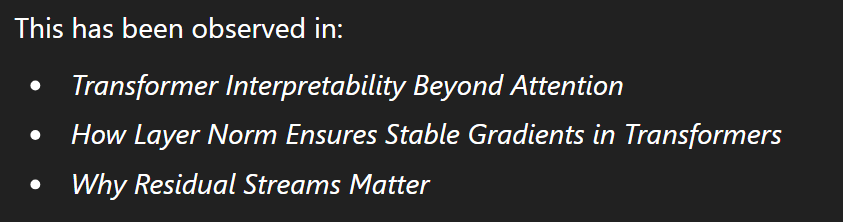

 - Attention detach (γ_AH) is not the dominant factor in relevance propagation — LayerNorm detach (γ_LN) is.

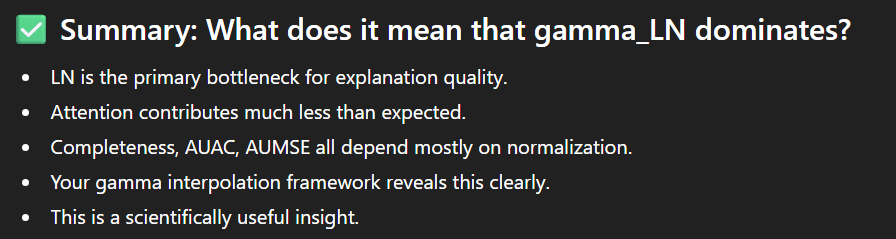